<a href="https://colab.research.google.com/github/firmansyahr/Production-Performance-Analysis-and-Continuous-Improvement/blob/main/Notebook/02_OEE_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 – Overall Equipment Effectiveness (OEE) Analysis

## Business Context
Overall Equipment Effectiveness (OEE) is a key metric to evaluate
manufacturing performance by integrating availability, performance,
and quality.

## Objectives
- Recalculate OEE from minute-level production data
- Analyze Availability, Performance, and Quality components
- Compare OEE across machines, shifts, and time
- Identify major OEE losses and improvement opportunities


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [ ]:
BASE_URL = "https://raw.githubusercontent.com/firmansyahr/Production-Performance-Analysis-and-Continuous-Improvement/"
BRANCH = "master"
RAW_PATH = f"{BASE_URL}{BRANCH}/data/raw/"

print("Loading data from:")
print(RAW_PATH)


Loading data from:
https://raw.githubusercontent.com/firmansyahr/Production-Performance-Analysis-and-Continuous-Improvement/master/data/raw/


In [ ]:
df_minutely = pd.read_csv(
    RAW_PATH + "factory_data.csv",
    parse_dates=["timestamp"]
)

df_oee_ref_day = pd.read_csv(
    RAW_PATH + "oee_by_day.csv"
)

df_oee_ref_shift = pd.read_csv(
    RAW_PATH + "oee_by_shift.csv"
)


In [ ]:
#Parameter & Assumptions
IDEAL_RATE = 6  # units per minute

## OEE Assumptions
- Ideal production rate = 6 units/minute
- Planned time = total minutes in period

In [ ]:
daily_oee_calc = (
    df_minutely
    .groupby(["day", "machine"])
    .agg(
        planned_min=("timestamp", "count"),
        running_min=("is_running", "sum"),
        total_units=("units", "sum"),
        good_units=("good_units", "sum")
    )
    .reset_index()
)

daily_oee_calc.head()


,day,machine,planned_min,running_min,total_units,good_units
0,2025-01-01,M1,1080,975,5874,5851
1,2025-01-01,M2,1080,1046,6354,6336
2,2025-01-02,M1,1440,1285,7861,7837
3,2025-01-02,M2,1440,1396,8348,8314
4,2025-01-03,M1,1440,1201,7207,7185


In [ ]:
daily_oee_calc["availability"] = (
    daily_oee_calc["running_min"] / daily_oee_calc["planned_min"]
)

daily_oee_calc["performance"] = (
    daily_oee_calc["total_units"] /
    (IDEAL_RATE * daily_oee_calc["running_min"])
)

daily_oee_calc["quality"] = (
    daily_oee_calc["good_units"] / daily_oee_calc["total_units"]
)

daily_oee_calc["oee"] = (
    daily_oee_calc["availability"] *
    daily_oee_calc["performance"] *
    daily_oee_calc["quality"]
)

daily_oee_calc.head()


,day,machine,planned_min,running_min,total_units,good_units,availability,performance,quality,oee
0,2025-01-01,M1,1080,975,5874,5851,0.902778,1.004103,0.996084,0.902932
1,2025-01-01,M2,1080,1046,6354,6336,0.968519,1.012428,0.997167,0.977778
2,2025-01-02,M1,1440,1285,7861,7837,0.892361,1.019585,0.996947,0.907060
3,2025-01-02,M2,1440,1396,8348,8314,0.969444,0.996657,0.995927,0.962269
4,2025-01-03,M1,1440,1201,7207,7185,0.834028,1.000139,0.996947,0.831597


In [ ]:
daily_oee_calc[[
    "availability",
    "performance",
    "quality",
    "oee"
]].describe()


,availability,performance,quality,oee
count,8.000000,8.000000,8.000000,8.000000
mean,0.909693,1.005665,0.996892,0.911434
std,0.062394,0.016868,0.000846,0.054031
min,0.834028,0.971296,0.995927,0.831597
25%,0.857813,0.999268,0.996212,0.873929
50%,0.897569,1.008265,0.996947,0.904996
75%,0.968750,1.018377,0.997185,0.964178
max,1.000000,1.023137,0.998570,0.977778


Expected:
- Availability between 0–1
- Performance generally ≤ 1
- Quality close to 1
- OEE between 0–1


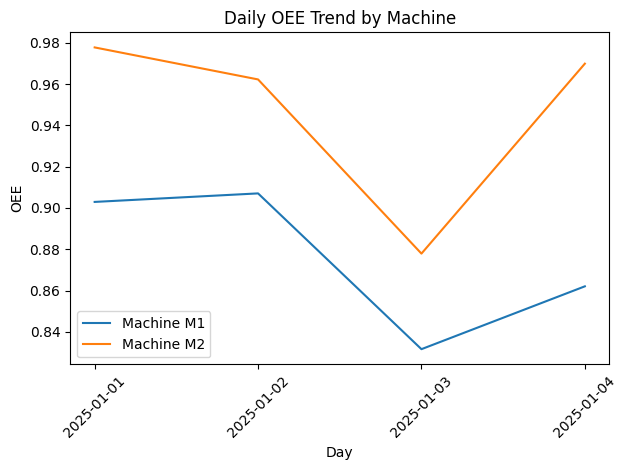

In [ ]:
#OEE Trend Over Time (Visualization)
plt.figure()
for machine in daily_oee_calc["machine"].unique():
    subset = daily_oee_calc[daily_oee_calc["machine"] == machine]
    plt.plot(subset["day"], subset["oee"], label=f"Machine {machine}")

plt.xlabel("Day")
plt.ylabel("OEE")
plt.title("Daily OEE Trend by Machine")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#OEE Component Breakdown (Average)
oee_component_avg = (
    daily_oee_calc
    .groupby("machine")[["availability", "performance", "quality"]]
    .mean()
    .reset_index()
)

oee_component_avg

,machine,availability,performance,quality
0,M1,0.869792,1.01045,0.996558
1,M2,0.949595,1.00088,0.997226


In [ ]:
#OEE by Shift
shift_oee_calc = (
    df_minutely
    .groupby(["day", "machine", "shift"])
    .agg(
        planned_min=("timestamp", "count"),
        running_min=("is_running", "sum"),
        total_units=("units", "sum"),
        good_units=("good_units", "sum")
    )
    .reset_index()
)

shift_oee_calc["availability"] = shift_oee_calc["running_min"] / shift_oee_calc["planned_min"]
shift_oee_calc["performance"] = shift_oee_calc["total_units"] / (IDEAL_RATE * shift_oee_calc["running_min"])
shift_oee_calc["quality"] = shift_oee_calc["good_units"] / shift_oee_calc["total_units"]
shift_oee_calc["oee"] = (
    shift_oee_calc["availability"] *
    shift_oee_calc["performance"] *
    shift_oee_calc["quality"]
)

shift_oee_calc.head()

,day,machine,shift,planned_min,running_min,total_units,good_units,availability,performance,quality,oee
0,2025-01-01,M1,A,480,430,2586,2576,0.895833,1.002326,0.996133,0.894444
1,2025-01-01,M1,B,480,425,2555,2545,0.885417,1.001961,0.996086,0.883681
2,2025-01-01,M1,C,120,120,733,730,1.000000,1.018056,0.995907,1.013889
3,2025-01-01,M2,A,480,480,2943,2937,1.000000,1.021875,0.997961,1.019792
4,2025-01-01,M2,B,480,446,2667,2657,0.929167,0.996637,0.996250,0.922569


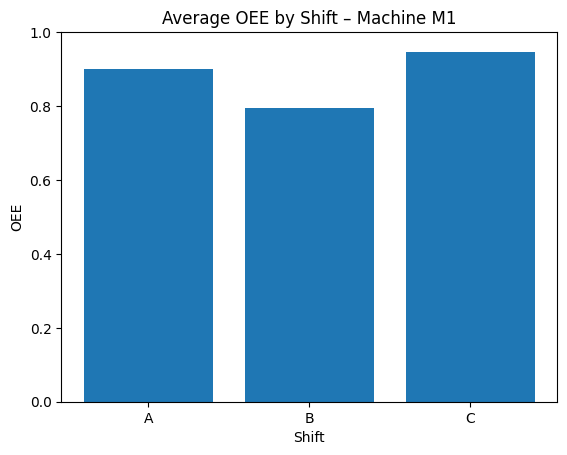

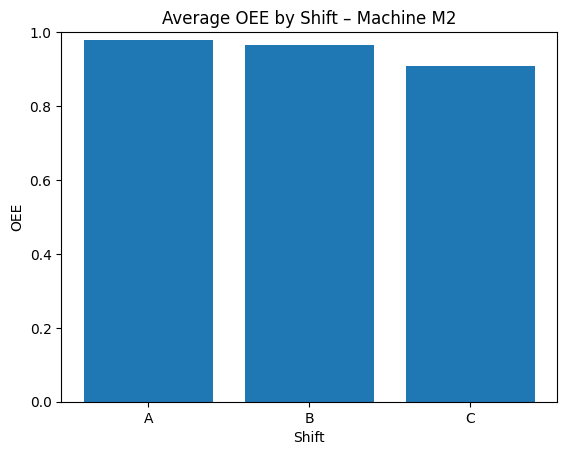

In [ ]:
#Shift Comparison
shift_avg = (
    shift_oee_calc
    .groupby(["machine", "shift"])["oee"]
    .mean()
    .reset_index()
)

for machine in shift_avg["machine"].unique():
    subset = shift_avg[shift_avg["machine"] == machine]
    plt.figure()
    plt.bar(subset["shift"], subset["oee"])
    plt.title(f"Average OEE by Shift – Machine {machine}")
    plt.xlabel("Shift")
    plt.ylabel("OEE")
    plt.ylim(0, 1)
    plt.show()


In [ ]:
#Comparison vs Reference OEE Dataset
oee_compare = daily_oee_calc.merge(
    df_oee_ref_day,
    on=["day", "machine"],
    how="left",
    suffixes=("_calc", "_ref")
)

oee_compare[[
    "day",
    "machine",
    "oee_calc",
    "oee_ref"
]].head()

,day,machine,oee_calc,oee_ref
0,2025-01-01,M1,0.902932,0.902932
1,2025-01-01,M2,0.977778,0.977778
2,2025-01-02,M1,0.907060,0.907060
3,2025-01-02,M2,0.962269,0.962269
4,2025-01-03,M1,0.831597,0.831597


In [ ]:
#OEE Difference Analysis
oee_compare["oee_diff"] = oee_compare["oee_calc"] - oee_compare["oee_ref"]

oee_compare["oee_diff"].describe()

,oee_diff
count,8.000000e+00
mean,1.387779e-17
std,3.925231e-17
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.110223e-16


Interpretation:
- Differences close to zero indicate consistency
- Systematic deviation may indicate rounding or assumption differences


## Key Insights

1. Overall Equipment Effectiveness (OEE) varies significantly across shifts,
   indicating operational differences rather than random fluctuation.

2. Availability is the primary driver of OEE loss, particularly on Machine M1,
   where average availability is approximately 8% lower than Machine M2.

3. Performance exceeds the defined ideal rate on both machines, suggesting
   that throughput capability is not a limiting factor and that the current
   ideal rate assumption may be conservative.

4. Quality remains consistently high (>99.6%) across all machines and shifts,
   indicating that scrap and defect rates are not contributing materially
   to OEE loss.

5. Shift-specific underperformance is observed:
   - Machine M1 performs weakest during Shift B
   - Machine M2 performs weakest during Shift C

6. These patterns suggest that improvement efforts should prioritize
   downtime reduction and availability optimization on specific
   machine–shift combinations rather than broad process changes.


#Summary

The production system demonstrates strong performance and quality
control. However, inconsistent availability across machines and shifts
leads to avoidable OEE losses. Targeted downtime reduction initiatives,
especially on Machine M1 during Shift B and Machine M2 during Shift C,
are expected to deliver the highest operational impact.